# House Pricing Prediction

In this notebook we will attempt to build and test a sales price prediction model based on a number of features. We will use statistical processes to wrangle the data, select features and create a model.

In [1]:
#import packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [59]:
#load test and train set for house prices in Iowa
train = pd.read_csv('train.csv', index_col='Id')
test = pd.read_csv('test.csv', index_col='Id')
test_ID = pd.read_csv('test.csv')['Id']

In [3]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [5]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [6]:
train.isnull().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

In [7]:
#Pre-processing data


## 2. Feature Selection/Testing

See excel template "Feature Variable Analysis.xlsx" for initial analysis on all variables. Below, I will provide the feature variables with a 'High' level of importance based on regression for numerical data and boxplots for categorical data (where finite).

I have split the features into 3 categorical segments:

**Building**: relates to physical characterstics (e.g. material used and shape)
<br>
**Space**: relates to numerical measurements of the area (e.g. LotArea or square feet above ground)
<br>
**Location**: relates to characteristics where the house is situatied (e.g. Neighborhood and flatness/level)

List of Final Features:

 - Neighborhood (Categorical/Location)
 - OverallQual (Categorical/Building)
 - YearBuilt (Categorical/Building)
 - ExterQual(Categorical/Building)
 - BsmtQual (Categorical/Building)
 - TotalBsmtSF (Numerical/Space)
 - GrLivArea (Numerical/Space)
 - FullBath (Categorical/Building)
 - KitchenQual (Categorical/Building)
 - GarageArea (Numerical/Space)
 
 7 Categorical, 3 Numerical<br>
 6 Building, 3 Space, 1 Location


### Feature #1: YearBuilt (Categorical/Building)

YearBuilt: Original Construction Date

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

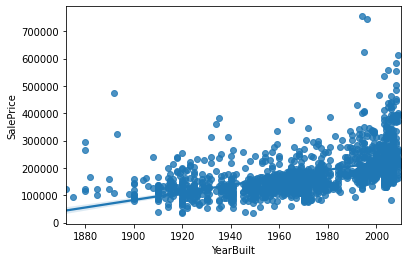

In [8]:
#regression plot
sns.regplot(x=train['YearBuilt'],y=train['SalePrice'])

### Feature #2: GrLivArea (Numerical)

GrLivArea: Above ground living area (square feet)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

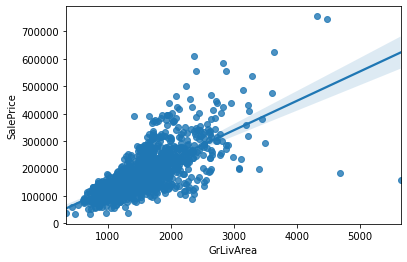

In [9]:
#regression plot
sns.regplot(x='GrLivArea',y='SalePrice', data=train)

### Feature #3: OverallQual (Categorical)

OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor

<AxesSubplot:xlabel='OverallQual', ylabel='count'>

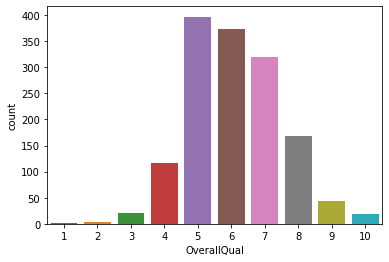

In [10]:
#count plot
sns.countplot(train['OverallQual'])

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

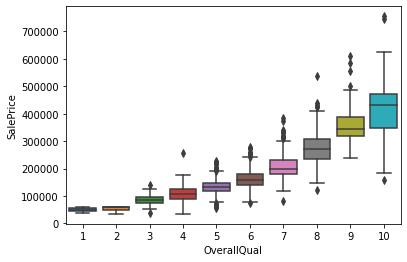

In [11]:
#box plot
sns.boxplot(y=train['SalePrice'],x=train['OverallQual'])

### Feature #4: Neighborhood (Categorical)

Neighborhood: Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker

<AxesSubplot:xlabel='count', ylabel='Neighborhood'>

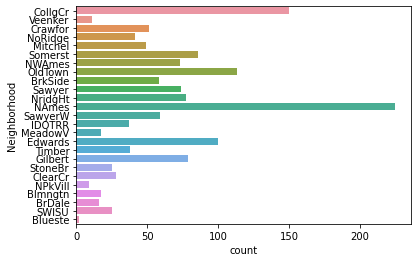

In [12]:
#count values
sns.countplot(y=train['Neighborhood'])

<AxesSubplot:xlabel='SalePrice', ylabel='Neighborhood'>

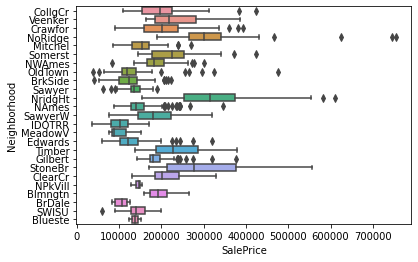

In [13]:
#box plot
sns.boxplot(x=train['SalePrice'],y=train['Neighborhood'])

### Featue #5: ExterQual (Categorical)

ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

<AxesSubplot:xlabel='ExterQual', ylabel='count'>

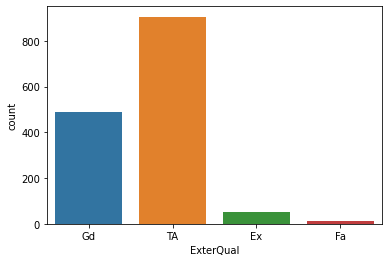

In [14]:
sns.countplot(train['ExterQual'])

<AxesSubplot:xlabel='ExterQual', ylabel='SalePrice'>

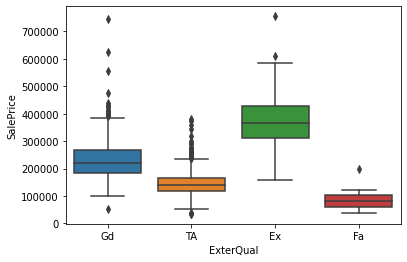

In [15]:
sns.boxplot(y=train['SalePrice'],x=train['ExterQual'])

### Feature #6 BsmtQual (Categorical)

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

<AxesSubplot:xlabel='BsmtQual', ylabel='count'>

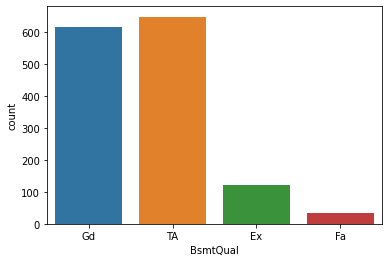

In [16]:
sns.countplot(train['BsmtQual'])

<AxesSubplot:xlabel='BsmtQual', ylabel='SalePrice'>

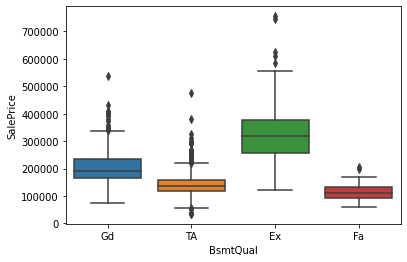

In [17]:
sns.boxplot(y=train['SalePrice'],x=train['BsmtQual'])

### Feature #7: TotalBsmtSF

TotalBsmtSF: Total square feet of basement area

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

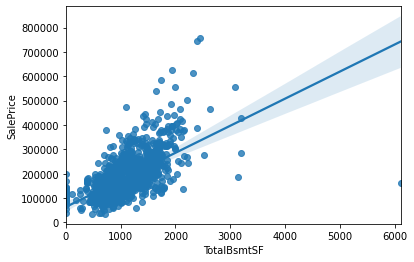

In [18]:
sns.regplot(x=train['TotalBsmtSF'],y=train['SalePrice'])

### Feature #8: FullBath

FullBath: Full bathrooms above ground

<AxesSubplot:xlabel='FullBath', ylabel='count'>

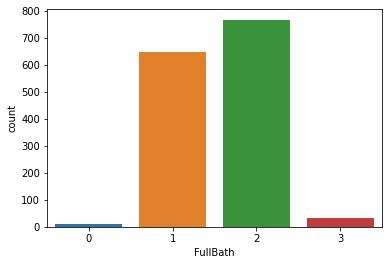

In [19]:
sns.countplot(train['FullBath'])

<AxesSubplot:xlabel='FullBath', ylabel='SalePrice'>

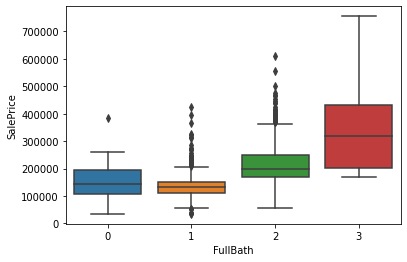

In [20]:
sns.boxplot(y=train['SalePrice'],x=train['FullBath'])

### Feature #9: KitchenQual

KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

<AxesSubplot:xlabel='KitchenQual', ylabel='count'>

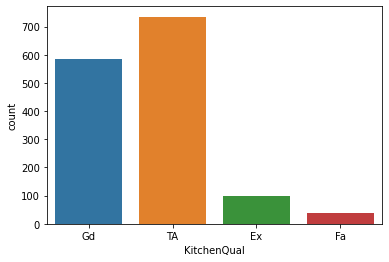

In [21]:
sns.countplot(train['KitchenQual'])

<AxesSubplot:xlabel='KitchenQual', ylabel='SalePrice'>

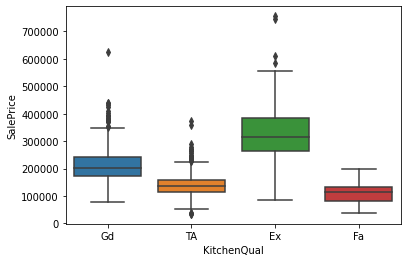

In [22]:
sns.boxplot(y=train['SalePrice'],x=train['KitchenQual'])

### Feature #10: GarageArea

GarageArea: Size of garage in square feet

<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice'>

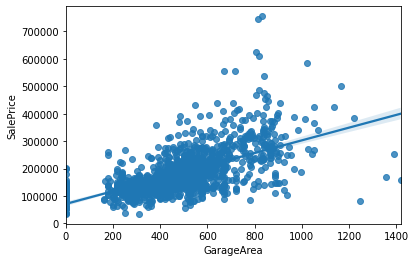

In [23]:
sns.regplot(x=train['GarageArea'],y=train['SalePrice'])

## 3. Analysising the Response Variable

In the next section we will analyse 'SalePrice'

In [24]:
# check min > 0
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

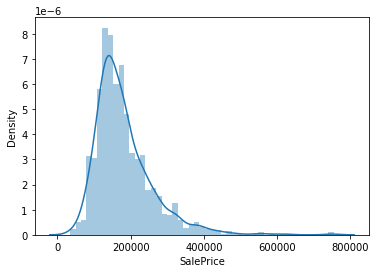

In [25]:
# histogram:

# deviate from normal
# positive skewness (tail on the right of mean)
# show kurtosis (long tail)

sns.distplot(train['SalePrice'])

In [26]:
# measure skewness and kurtosis

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


## 4. Pre-processing

In order for our model to make predictions, we must give it numerical data. In this section we will start by converting our categorical data (non-numerical) into numerical. There are three main ways of doing this, two of which from the sklearn package:

 - LabelEncoder
 - OneHotEncoder
 - DummyEncoder
 
They each have their benefits and drawbacks. 

### LabelEncoder
 
<b> LabelEncoder </b> takes each category and assigns a number from 0 - (n-1) creating one new column. This is simple, but can be a problem for unordered categories such as our <b> Neighborhood </b> feature, because the model may assume a higher number should be weighted by a factor compared to 0, for example.

In [27]:
# example converting Neighborhood to numerical using LabelEncoder
df_encoder = pd.DataFrame(train['Neighborhood'].unique(), columns = ['Neighborhood'])

le = LabelEncoder()
df_encoder['Neighborhood_E'] = le.fit_transform(df_encoder['Neighborhood'])
df_encoder.sort_values('Neighborhood')


,Neighborhood,Neighborhood_E
21,Blmngtn,0
24,Blueste,1
22,BrDale,2
8,BrkSide,3
19,ClearCr,4
0,CollgCr,5
2,Crawfor,6
15,Edwards,7
17,Gilbert,8
13,IDOTRR,9


### OneHotEncoder

For unordered categories we can use <b> OneHotEncoder </b> which will create n extra columns for each category, asigning a 1 for each row in that category and a 0 otherwise. Essentially this creates an n x n identity matrix as a mapping for all the categories. Like so:

In [28]:
#example of OneHotEncoder for Neighborhood
enc = OneHotEncoder(handle_unknown='ignore')

df_enc = pd.DataFrame(enc.fit_transform(df_encoder[['Neighborhood_E']]).toarray())

df_encoder = df_encoder.join(df_enc)
df_encoder.sort_values('Neighborhood')

,Neighborhood,Neighborhood_E,0,1,2,3,4,5,6,7,...,15,16,17,18,19,20,21,22,23,24
21,Blmngtn,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,Blueste,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,BrDale,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,BrkSide,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,ClearCr,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,CollgCr,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Crawfor,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,Edwards,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,Gilbert,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,IDOTRR,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### DummyEncoder

A problem with <b> OneHotEncoder </b> is that it can create many sparse features which are multicolinear. This isn't usually an issue for most machine learning models, but it can cause a multitude of complication for regression models including overfitting. In regresison we aim for high correlation in response variable, with low correlation among the feature variables.

Another issue with OneHotEncoder is that in tree-based ensembles, such as <b> RandomForest </b> (which we will use later down the road), the tree will start to split down a single line into sparse features. Imagine for the Neighborhood example below, it may start to check each feature and split a 0 or 1 for all 24 categories, leading to overfitting and other complications.

A solution to this is <b> DummyEncoder </b> which essentially drops features (usually 1) to reduce multicolinearity. The reason this works well is because even if the category dropped is important, it is still represented as a 0 for all other categories.

We will create a function below to run this with the option to drop the first category or/and include NA as a feature:

In [29]:
# --|ReplaceDummyEncoder|--
# accept a DataFrame (df) and list of columns to parse (cols) thn split categories for each column in the list
# into a matrix of n-1 columns, where n is the number of categories and append to dataframe, replacing the original column.

def ReplaceDummyEncoder(df, cols, include_na = True, drop_first = True):
    #create matrix of DummyEncoding with N-k columns of total categories (N) - number of input columns (k)
    dummy = pd.get_dummies(df[cols],dummy_na = include_na, drop_first=drop_first)
    
    #merge dataframe with new matrix of categories and remove original columns
    df_temp = df.merge(dummy, left_index = True, right_index = True)
    df_temp = df_temp.drop(cols, axis=1)
    
    #return replacement dataframe
    return df_temp

In [30]:
# list of columns to DummyEncode with meaningful NA
unordered= ['Alley','Fence']


#list of columns to DummyEncode without meaningful NA
unordered_excl_na = ['Neighborhood','MSZoning']

#list of columns to LabelEncode

#replace train
train = ReplaceDummyEncoder(train, unordered, include_na = True, drop_first = True)
train = ReplaceDummyEncoder(train, unordered_excl_na, include_na = False, drop_first = True)

#replace test
test = ReplaceDummyEncoder(test, unordered, include_na = True, drop_first = True)
test = ReplaceDummyEncoder(test, unordered_excl_na, include_na = False, drop_first = True)

In [31]:
train.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,...,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,...,0,0,0,0,0,0,0,0,1,0
2,20,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Feedr,...,0,0,0,0,0,1,0,0,1,0
3,60,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,Norm,...,0,0,0,0,0,0,0,0,1,0
4,70,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,...,0,0,0,0,0,0,0,0,1,0
5,60,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,Norm,...,0,0,0,0,0,0,0,0,1,0


### Selecting Method of Encoding

Now that we have seen an example of the two main encoding mechanisms. We must now look at our categorical variables and select the most appropriate form of encoding. Remembering that if the category would benefit from an extra dimension of ranking, we should use LabelEncoder, whereas if it is better as an unordered list, we should use OneHotEncoder.

In total we have 60 categorical features out of the 78 variables, most of which will require OneHotEncoding. So this will take some time, but we will go through each on and amend our "Feature Variable Analysis.xlsx" file:

Firstly, let's take <b> MSSubClass </b> which actually looks relatively ordered through the labelling (higher number looks to reflect more space)

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

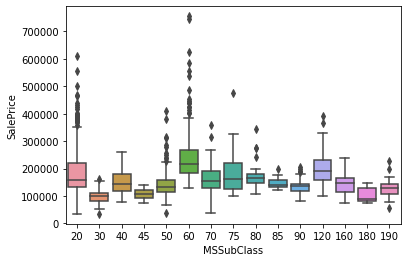

In [32]:
sns.boxplot(y=train['SalePrice'], x=train['MSSubClass'])

From this we can see that there is some differences, but it is not a linear representation, so OneHotEncoder for now.

We can repeat this for our other categories and get the following result:


In [33]:
## ---- START HERE: Create a function to OneHotEncode based on NA's meaningful and list of categorical features

## 5. Relationship of 'SalePrice' with feature variables

Here we will analyse the relationship between our response variable 'SalePrice' and feature variables using Correlation matrices, heatmaps and scatter plots.

<AxesSubplot:>

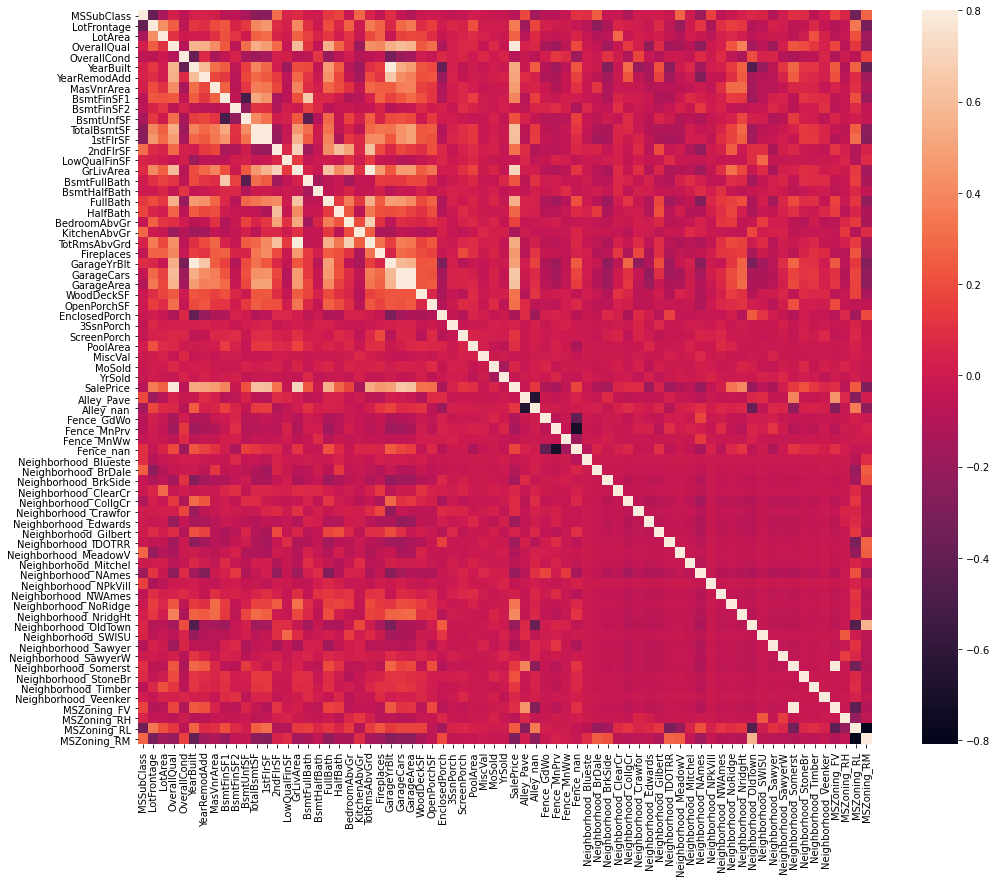

In [34]:
#correlation matrix and heatmap for numerical variables
corrmat = train.corr()
fig, ax = plt.subplots(figsize=(18,13.5))
sns.heatmap(corrmat, vmax = 0.8, square = True)

In [35]:
# finding top k variables by correlation with 'SalePrice'
k = 15
corrmat.nlargest(k,'SalePrice')['SalePrice']

SalePrice               1.000000
OverallQual             0.790982
GrLivArea               0.708624
GarageCars              0.640409
GarageArea              0.623431
TotalBsmtSF             0.613581
1stFlrSF                0.605852
FullBath                0.560664
TotRmsAbvGrd            0.533723
YearBuilt               0.522897
YearRemodAdd            0.507101
GarageYrBlt             0.486362
MasVnrArea              0.477493
Fireplaces              0.466929
Neighborhood_NridgHt    0.402149
Name: SalePrice, dtype: float64

In the above heatmap we have set a ceiling of 0.8 correlation, the idea is to avoid co-linearity by identifying groups of features which are being described by each other. For example: <b>GarageCars</b> and <b>GarageArea</b> have an R value of >=0.8 and hence we can drop one in favour of the other.

In [36]:
train_drop = train.drop(['MSZoning_RM', 'GarageArea','Fence_MnPrv','Alley_Pave', '1stFlrSF'], axis=1)

<AxesSubplot:>

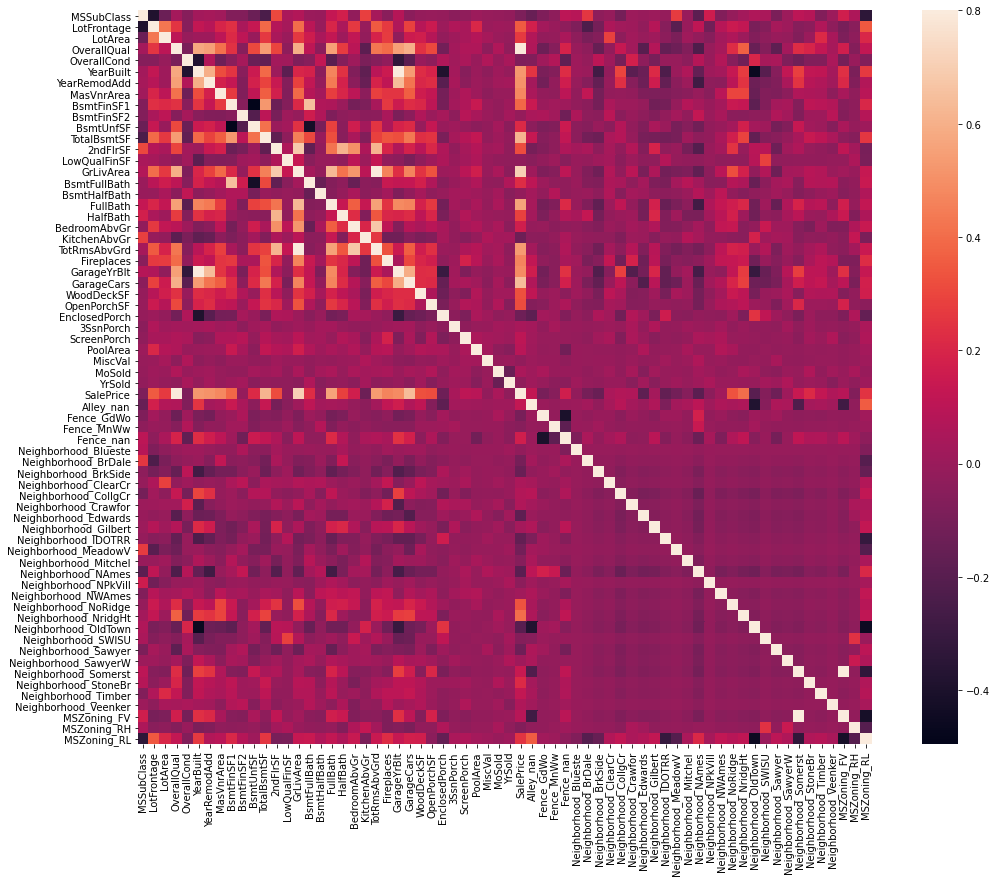

In [37]:
# re-init correlation matrix
corrmat_drop = train_drop.corr()
fig, ax = plt.subplots(figsize=(18,13.5))
sns.heatmap(corrmat_drop, vmax = 0.8, square = True)

In [38]:
# finding top k variables by correlation with 'SalePrice'
k = 15
features_corr = corrmat_drop.nlargest(k,'SalePrice')['SalePrice']
features_corr

SalePrice               1.000000
OverallQual             0.790982
GrLivArea               0.708624
GarageCars              0.640409
TotalBsmtSF             0.613581
FullBath                0.560664
TotRmsAbvGrd            0.533723
YearBuilt               0.522897
YearRemodAdd            0.507101
GarageYrBlt             0.486362
MasVnrArea              0.477493
Fireplaces              0.466929
Neighborhood_NridgHt    0.402149
BsmtFinSF1              0.386420
LotFrontage             0.351799
Name: SalePrice, dtype: float64

In [39]:
train[features_corr.keys()].isnull().sum()

SalePrice                 0
OverallQual               0
GrLivArea                 0
GarageCars                0
TotalBsmtSF               0
FullBath                  0
TotRmsAbvGrd              0
YearBuilt                 0
YearRemodAdd              0
GarageYrBlt              81
MasVnrArea                8
Fireplaces                0
Neighborhood_NridgHt      0
BsmtFinSF1                0
LotFrontage             259
dtype: int64

In [40]:
train['SalePrice'].isnull().sum()

0

In [41]:
# Now seperate the feature and response variables
features = features_corr.keys()

#----dropped to test model -> re-add with accounting for NaN
features = features.drop(['GarageYrBlt','MasVnrArea','LotFrontage','SalePrice'])

X = train[features]
y = train['SalePrice']

X_test = test[features]

In [42]:
#fill_na with mean of column for testing
X_test = X_test.apply(lambda x: x.fillna(x.mean()), axis=0)
X_test.describe()

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,Fireplaces,Neighborhood_NridgHt,BsmtFinSF1
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1459.000000,1459.000000
mean,6.078821,1486.045922,1.766118,1046.117970,1.570939,6.385195,1971.357779,1983.662783,0.58122,0.061001,439.203704
std,1.436812,485.566099,0.775679,442.746712,0.555190,1.508895,30.390071,21.130467,0.64742,0.239414,455.111888
min,1.000000,407.000000,0.000000,0.000000,0.000000,3.000000,1879.000000,1950.000000,0.00000,0.000000,0.000000
25%,5.000000,1117.500000,1.000000,784.000000,1.000000,5.000000,1953.000000,1963.000000,0.00000,0.000000,0.000000
50%,6.000000,1432.000000,2.000000,988.000000,2.000000,6.000000,1973.000000,1992.000000,0.00000,0.000000,351.000000
75%,7.000000,1721.000000,2.000000,1304.000000,2.000000,7.000000,2001.000000,2004.000000,1.00000,0.000000,752.000000
max,10.000000,5095.000000,5.000000,5095.000000,4.000000,15.000000,2010.000000,2010.000000,4.00000,1.000000,4010.000000


In [43]:
#Train and Test splitting of data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

#Random Forest
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(X_train, y_train)
SalePrice_pred = forest_model.predict(X_val)
print(mean_absolute_error(y_val, SalePrice_pred))

17798.51815068493


## 6. Predict Test

Finally, we predict the test sales price and submit

In [44]:
# predict test for submission
Sale_Price_test_pred = forest_model.predict(X_test)

In [60]:
#submission format
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = Sale_Price_test_pred

sub.to_csv('submission.csv', index=False)

In [45]:
#Apply standard scaling to get optimized result
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.fit_transform(X_test)

#ERROR:: due to strings, need to only standardize numerical data

In [46]:
reg = linear_model.LinearRegression()

NameError: name 'linear_model' is not defined